# Exploring the TensorFlow models

In this notebook we will utilise some simple dense neural networks in finding Ricci-flat Calabi-Yau metrics. 
In particular we will make use of the following three tensorflow models.

1. *MultFSModel*: uses the following Ansatz for the CY metric: $g_{pred} = g_{FS} ( 1 + g_{NN})$.
2. *PhiFSModel*: uses the following Ansatz for the CY metric: $g_{pred} = g_{FS} + \partial \bar{\partial} \phi_{NN}$.
2. *ToricPhiFSModel*: is the same as *PhiFSModel*, but for toric CYs.

This notebook assumes that [1.PointGenerator](1.PointGenerator.ipynb) has generated datasets for the Fermat quintic.

In [1]:
import numpy as np
import os as os
import tensorflow as tf
tfk = tf.keras

## MultFSModel 

The *MultFSModel* works for any CICY.

### Data preprocessing

We load the dataset and also the generated basis from *PointGenerator*

In [6]:
dirname = 'fermat_pg'

In [7]:
data = np.load(os.path.join(dirname, 'dataset.npz'))
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)

tensorflow can only compute derivatives w.r.t. tensor objects. Thus we transform the *BASIS* using

In [8]:
from cymetric.models.helper import prepare_basis, train_model

In [9]:
BASIS = prepare_basis(BASIS)

Our integration weights set the overall volume of the CY. This parameter is usually denoted with $\kappa$ and contributes directly in the MA equation.

In [10]:
kappa = np.real(BASIS['KAPPA'])
kappa

np.float64(0.01758977139384217)

### NN set up

The *cymetric*-TensorFlow models are custom models and come with custom needs. We have written several callbacks and metrics to track the training progress.

In [11]:
from cymetric.models.callbacks import RicciCallback, SigmaCallback, VolkCallback, KaehlerCallback, TransitionCallback
from cymetric.models.models import MultFSModel

We define some callbacks to evaluate the performance of our models on the

1. Ricci-measure
2. Sigma-measure
3. Volume

In [12]:
rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
scb = SigmaCallback((data['X_val'], data['y_val']))
volkcb = VolkCallback((data['X_val'], data['y_val']))
kcb = KaehlerCallback((data['X_val'], data['y_val']))
tcb = TransitionCallback((data['X_val'], data['y_val']))
cb_list = [rcb, scb, kcb, tcb, volkcb]

set some hyperparameters for the NN

In [13]:
nlayer = 3
nHidden = 64
act = 'gelu'
nEpochs = 5
bSizes = [64, 50000]
alpha = [1., 1., 1., 1., 1.]
nfold = 3
n_in = 2*5
n_out = nfold**2

and finally set up the neural net

In [12]:
nn = tf.keras.Sequential()
nn.add(tfk.Input(shape=(n_in,)))
for i in range(nlayer):
    nn.add(tfk.layers.Dense(nHidden, activation=act))
nn.add(tfk.layers.Dense(n_out, use_bias=False))

the *MultFSModel* requires as arguments 

1. the nn, which we have defined above, 
2. the *PointGenerator*-*BASIS* which contains all relevant information of the underlying Calabi-Yau.

It has optional arguments for

1. The overall volume of the CY. We give kappa to stay at the same volume as the integration weights.
2. alpha, which weights the different loss contributions (1-MA loss, 2-Kähler loss, 3-transition loss, 4-Ricci loss (by default disabled), 5-volk loss).

In [14]:
fmodel = MultFSModel(nn, BASIS, alpha=alpha)

we use the optimizer

In [15]:
opt = tfk.optimizers.Adam()

compile and train the model

In [16]:
fmodel, training_history = train_model(fmodel, data, optimizer=opt, epochs=nEpochs, batch_sizes=bSizes, verbose=1, callbacks=cb_list)


Epoch  1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - kaehler_loss: 0.0055 - loss: 0.1819 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1657 - transition_loss: 0.0107 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - kaehler_loss: 0.0071 - loss: 0.1141 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0978 - transition_loss: 0.0092 - volk_loss: 0.0000e+00

2025-07-17 19:24:26.991278: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 - Ricci measure val:      1.2170
 - Sigma measure val:      0.1016


2025-07-17 19:24:27.816541: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 - Kaehler measure val:    0.0071
 - Transition measure val: 0.0092
 - Volk val:               4.8890
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - kaehler_loss: 0.0071 - loss: 0.1144 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0981 - transition_loss: 0.0092 - volk_loss: 0.0000e+00 - ricci_val: 1.2170 - sigma_val: 0.1016 - kaehler_val: 0.0071 - transition_val: 0.0092 - volk_val: 4.8890

Epoch  2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - kaehler_loss: 0.0063 - loss: 0.1079 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0945 - transition_loss: 0.0071 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - kaehler_loss: 0.0057 - loss: 0.1030 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0919 - transition_loss: 0.0054 - volk_loss: 0.0000e+00 - Ricci measure val:      1.0993
 - Sigma measure val:      0.0946
 - Kaehler measure val:    0.0057
 - Transition measure val: 0.0053
 - Volk val:               5.0301
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - kaehler_loss: 0.0057 - loss: 0.1029 - ricci_loss: 0.0

2025-07-17 19:24:36.901192: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - kaehler_loss: 0.0054 - loss: 0.0989 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0893 - transition_loss: 0.0042 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - kaehler_loss: 0.0047 - loss: 0.1054 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0975 - transition_loss: 0.0032 - volk_loss: 0.0000e+00 - Ricci measure val:      1.0320
 - Sigma measure val:      0.0916
 - Kaehler measure val:    0.0048
 - Transition measure val: 0.0033
 - Volk val:               4.9650
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - kaehler_loss: 0.0047 - loss: 0.1044 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0965 - transition_loss: 0.0032 - volk_loss: 0.0000e+00 - ricci_val: 1.0320 - sigma_val: 0.0916 - kaehler_val: 0.0048 - transition_val: 0.0033 - volk_val: 4.9650

Epoch  4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - kaehler_loss: 0.0049 - loss: 0.0956 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0876 - transition_loss: 0.0030 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━

2025-07-17 19:24:55.861326: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - kaehler_loss: 0.0048 - loss: 0.0938 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0863 - transition_loss: 0.0027 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - kaehler_loss: 0.0046 - loss: 0.1064 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0992 - transition_loss: 0.0026 - volk_loss: 0.0000e+00 - Ricci measure val:      1.0719
 - Sigma measure val:      0.0981
 - Kaehler measure val:    0.0045
 - Transition measure val: 0.0026
 - Volk val:               5.0025
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - kaehler_loss: 0.0046 - loss: 0.1070 - ricci_loss: 0.0000e+00 - sigma_loss: 0.0998 - transition_loss: 0.0026 - volk_loss: 0.0000e+00 - ricci_val: 1.0719 - sigma_val: 0.0981 - kaehler_val: 0.0045 - transition_val: 0.0026 - volk_val: 5.0025


In the training process the ricci_loss is zero, because it has been disabled so we don't have to compute two additional derivatives during training. We keep track of the Ricci measure with the callbacks. The volume computed for the validation set (volk val) should be 5, which is $\int_X J^3$ for the quintic with Kahler parameter $t=1$.

In [17]:
for key in sorted(training_history.keys()):
    print(key)

epochs
kaehler_loss
kaehler_val
loss
ricci_loss
ricci_val
sigma_loss
sigma_val
transition_loss
transition_val
volk_loss
volk_val


### Fancy plots

and make some fancy plots. The packages below are not required for *cymetric*, so you might have to install them by hand.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")

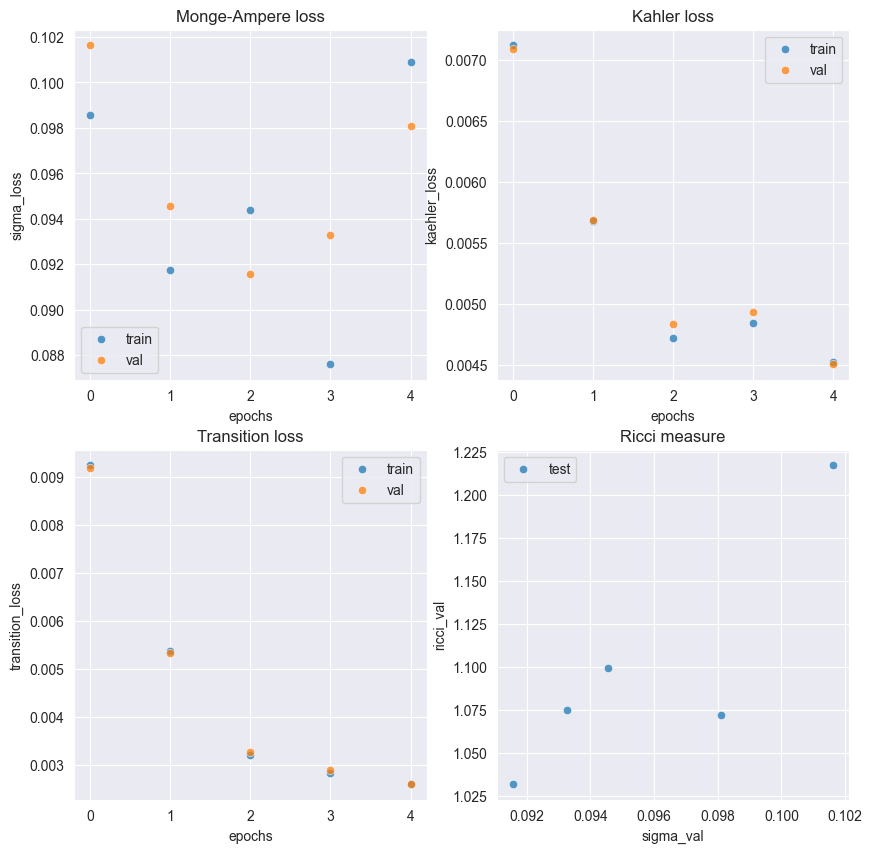

In [19]:
hist = training_history
hist['epochs'] = list(range(nEpochs))
hist_data = pd.DataFrame(hist)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title("Monge-Ampere loss")
sns.scatterplot(x='epochs', y='sigma_loss', data=hist_data, alpha=0.75, ax=ax1, label="train")
sns.scatterplot(x='epochs', y='sigma_val', data=hist_data, alpha=0.75, ax=ax1, label="val")

ax2.set_title("Kahler loss")
sns.scatterplot(x='epochs', y='kaehler_loss', data=hist_data, alpha=0.75, ax=ax2, label="train")
sns.scatterplot(x='epochs', y='kaehler_val', data=hist_data, alpha=0.75, ax=ax2, label="val")

ax3.set_title("Transition loss")
sns.scatterplot(x='epochs', y='transition_loss', data=hist_data, alpha=0.75, ax=ax3, label="train")
sns.scatterplot(x='epochs', y='transition_val', data=hist_data, alpha=0.75, ax=ax3, label="val")

ax4.set_title("Ricci measure")
sns.scatterplot(x='sigma_val', y='ricci_val', data=hist_data, alpha=0.75, ax=ax4, label="test");

and we find a nice slope going towards the origin for optimization of the MA equation.

## The PhiFSModel

is set up similar to the *MultFSModel*.

### The NN

now has a single output. We disable the bias in the last layer, because it's contribution will also be zero after taking the two derivatives w.r.t to the input coordinates.

In [21]:
n_out = 1
nn_phi = tf.keras.Sequential()
nn_phi.add(tfk.Input(shape=(n_in, )))
for i in range(nlayer):
    nn_phi.add(tfk.layers.Dense(nHidden, activation=act))
nn_phi.add(tfk.layers.Dense(n_out, use_bias=False))

In [22]:
from cymetric.models.models import PhiFSModel

In [23]:
phimodel = PhiFSModel(nn_phi, BASIS, alpha=alpha)
opt_phi = tfk.optimizers.Adam()

and fit

In [24]:
phimodel, training_history = train_model(phimodel, data, optimizer=opt_phi, epochs=nEpochs, batch_sizes=bSizes, verbose=1, callbacks=cb_list)


Epoch  1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kaehler_loss: 0.0000e+00 - loss: 0.2222 - ricci_loss: 0.0000e+00 - sigma_loss: 0.2152 - transition_loss: 0.0070 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1940 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1896 - transition_loss: 0.0044 - volk_loss: 0.0000e+00 - Ricci measure val:      0.9249
 - Sigma measure val:      0.1646
 - Kaehler measure val:    1.2894e-15
 - Transition measure val: 0.0036
 - Volk val:               4.2571
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 8s/step - kaehler_loss: 0.0000e+00 - loss: 0.1936 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1893 - transition_loss: 0.0043 - volk_loss: 0.0000e+00 - ricci_val: 0.9249 - sigma_val: 0.1646 - kaehler_val: 1.2894e-15 - transition_val: 0.0036 - volk_val: 4.2571

Epoch  2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1550 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1523 - transition_loss: 0.0027 - vo

2025-07-17 19:26:56.071393: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch  4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1473 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1450 - transition_loss: 0.0024 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1388 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1360 - transition_loss: 0.0027 - volk_loss: 0.0000e+00 - Ricci measure val:      1.0791
 - Sigma measure val:      0.1449
 - Kaehler measure val:    1.3172e-15
 - Transition measure val: 0.0022
 - Volk val:               4.6861
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - kaehler_loss: 0.0000e+00 - loss: 0.1382 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1355 - transition_loss: 0.0026 - volk_loss: 0.0000e+00 - ricci_val: 1.0791 - sigma_val: 0.1449 - kaehler_val: 1.3172e-15 - transition_val: 0.0022 - volk_val: 4.6861

Epoch  5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1387 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1363 - transition_loss: 0.0025 - vo

we find that in addition to the ricci-loss also the kaehler-loss is zero. These latter is satisfied by construction in the $\phi$-network and thus disabled.

## The ToricPhiFSModel

requires additional toric data.

### The NN

is the same as for the *PhiFSModel*.

In [10]:
n_in = 2*5
nlayer = 3
nHidden = 64
act = 'gelu'

nEpochs = 10
bSizes = [64, 50000]

nfold = 3
n_out = 1
alpha = [1., 1., 1., 1., 1.]
nn_phit = tf.keras.Sequential()
nn_phit.add(tfk.Input(shape=(n_in, )))
for i in range(nlayer):
    nn_phit.add(tfk.layers.Dense(nHidden, activation=act))
nn_phit.add(tfk.layers.Dense(n_out, use_bias=False))

In [16]:
from cymetric.models.models import PhiFSModelToric
from cymetric.models.callbacks import RicciCallback, SigmaCallback, VolkCallback, KaehlerCallback, TransitionCallback
from cymetric.models.helper import prepare_basis, train_model


load toric data

In [17]:
dirname = 'fermat_pgtoricmath'
toric_data = np.load(os.path.join(dirname, 'toric_data.pickle'), allow_pickle=True)
data = np.load(os.path.join(dirname, 'dataset.npz'))
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)
BASIS = prepare_basis(BASIS)

In [18]:
phimodel_toric = PhiFSModelToric(nn_phit, BASIS, alpha=alpha, toric_data=toric_data)
opt_phit = tfk.optimizers.Adam()

rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
scb = SigmaCallback((data['X_val'], data['y_val']))
volkcb = VolkCallback((data['X_val'], data['y_val']))
kcb = KaehlerCallback((data['X_val'], data['y_val']))
tcb = TransitionCallback((data['X_val'], data['y_val']))
cb_list = [rcb, scb, kcb, tcb, volkcb]

and fit

In [19]:
phimodel_toric, training_history = train_model(phimodel_toric, data, optimizer=opt_phit, epochs=nEpochs, batch_sizes=bSizes, verbose=1, callbacks=cb_list)


Epoch  1/10
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - kaehler_loss: 0.0000e+00 - loss: 0.3483 - ricci_loss: 0.0000e+00 - sigma_loss: 0.3288 - transition_loss: 0.0195 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - kaehler_loss: 0.0000e+00 - loss: 0.3189 - ricci_loss: 0.0000e+00 - sigma_loss: 0.3001 - transition_loss: 0.0188 - volk_loss: 0.0000e+00

2025-07-18 13:57:57.293137: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 - Ricci measure val:      3.6325
 - Sigma measure val:      0.3355


2025-07-18 13:58:02.568693: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 - Kaehler measure val:    1.7629e-14
 - Transition measure val: 0.0205
 - Volk val:               4.0210
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 14s/step - kaehler_loss: 0.0000e+00 - loss: 0.3188 - ricci_loss: 0.0000e+00 - sigma_loss: 0.3000 - transition_loss: 0.0189 - volk_loss: 0.0000e+00 - ricci_val: 3.6325 - sigma_val: 0.3355 - kaehler_val: 1.7629e-14 - transition_val: 0.0205 - volk_val: 4.0210

Epoch  2/10
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kaehler_loss: 0.0000e+00 - loss: 0.3006 - ricci_loss: 0.0000e+00 - sigma_loss: 0.2827 - transition_loss: 0.0179 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - kaehler_loss: 0.0000e+00 - loss: 0.2739 - ricci_loss: 0.0000e+00 - sigma_loss: 0.2588 - transition_loss: 0.0151 - volk_loss: 0.0000e+00 - Ricci measure val:      3.4501
 - Sigma measure val:      0.2970


2025-07-18 13:58:13.326522: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 - Kaehler measure val:    1.7867e-14
 - Transition measure val: 0.0156
 - Volk val:               4.0662
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - kaehler_loss: 0.0000e+00 - loss: 0.2739 - ricci_loss: 0.0000e+00 - sigma_loss: 0.2583 - transition_loss: 0.0156 - volk_loss: 0.0000e+00 - ricci_val: 3.4501 - sigma_val: 0.2970 - kaehler_val: 1.7867e-14 - transition_val: 0.0156 - volk_val: 4.0662

Epoch  3/10
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kaehler_loss: 0.0000e+00 - loss: 0.2609 - ricci_loss: 0.0000e+00 - sigma_loss: 0.2456 - transition_loss: 0.0152 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - kaehler_loss: 0.0000e+00 - loss: 0.2418 - ricci_loss: 0.0000e+00 - sigma_loss: 0.2302 - transition_loss: 0.0117 - volk_loss: 0.0000e+00 - Ricci measure val:      3.4505
 - Sigma measure val:      0.2690
 - Kaehler measure val:    1.8793e-14
 - Transition measure val: 0.0123
 - Volk val:               4.3657
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - kaehler_loss: 0.0000e+00 - l

2025-07-18 13:58:33.942086: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 - Kaehler measure val:    1.9033e-14
 - Transition measure val: 0.0120
 - Volk val:               4.2689
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - kaehler_loss: 0.0000e+00 - loss: 0.2203 - ricci_loss: 0.0000e+00 - sigma_loss: 0.2065 - transition_loss: 0.0137 - volk_loss: 0.0000e+00 - ricci_val: 3.0898 - sigma_val: 0.2470 - kaehler_val: 1.9033e-14 - transition_val: 0.0120 - volk_val: 4.2689

Epoch  5/10
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kaehler_loss: 0.0000e+00 - loss: 0.2098 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1980 - transition_loss: 0.0118 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - kaehler_loss: 0.0000e+00 - loss: 0.2016 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1891 - transition_loss: 0.0124 - volk_loss: 0.0000e+00 - Ricci measure val:      3.1475
 - Sigma measure val:      0.2269
 - Kaehler measure val:    1.9547e-14
 - Transition measure val: 0.0114
 - Volk val:               4.4749
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - kaehler_loss: 0.0000e+00 - l

2025-07-18 13:59:14.760614: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 - Kaehler measure val:    1.9779e-14
 - Transition measure val: 0.0106
 - Volk val:               4.4219
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - kaehler_loss: 0.0000e+00 - loss: 0.1681 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1569 - transition_loss: 0.0112 - volk_loss: 0.0000e+00 - ricci_val: 2.8988 - sigma_val: 0.1972 - kaehler_val: 1.9779e-14 - transition_val: 0.0106 - volk_val: 4.4219

Epoch  9/10
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1673 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1572 - transition_loss: 0.0101 - volk_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1607 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1511 - transition_loss: 0.0096 - volk_loss: 0.0000e+00 - Ricci measure val:      2.9072
 - Sigma measure val:      0.1903
 - Kaehler measure val:    2.0230e-14
 - Transition measure val: 0.0097
 - Volk val:               4.4994
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - kaehler_loss: 0.0000e+00 - l